# Lunar Craters Detection using Deep Learning
> * 🔬 Data Science
> * 🥠 Deep Learning

## Table of Contents

* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Methodology](#Methodology)
* [Export training data](#Export-training-data)
* [Model training](#Model-training)
  * [Prepare data](#Prepare-data)
  * [Load MaskRCNN model architecture](#Load-Pix2Pix-model-architecture)
  * [Tuning for optimal learning rate](#Tuning-for-optimal-learning-rate)
  * [Fit the model](#Fit-the-model)
  * [Visualize results in validation set](#Visualize-results-in-validation-set)
  * [Save the model](#Save-the-model)
  * [Accuracy assessment](#Accuracy-assessment)
* [Model inferencing](#Model-inferencing)
* [Results visualization](#1)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction 

When ground data is not available, crater detection and counting play a vital role in predicting the moons surface age. Further, crater detection is necessary for identifying viable landing sites for lunar landers, as well as for establishing landmarks for navigation on the moon. Traditionally, craters have manually been digitized using visual interpretation, a very time-consuming and inefficient method. However, with the proliferation of deep learning, the process of crater detection is now able to be bolstered by automated detection. This notebook will demonstrate how the [ArcGIS API for Python](https://developers.arcgis.com/python/) can be used to train a deep learning crater detection model using a Digital Elevation Model (DEM), which can then be deployed in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) or [ArcGIS Enterprise](https://www.esri.com/en-us/arcgis/products/arcgis-enterprise/overview).

## Necessary imports

In [1]:
import os
from pathlib import Path

from arcgis import GIS
from arcgis.learn import MaskRCNN, prepare_data

 ## Connect to your GIS

In [2]:
gis = GIS('home')

## Export training data

The DEM of the moon will be used as `input_raster` for the training data and has a spatial resolution of 118m. It can be downloaded from the [USGS](https://astrogeology.usgs.gov/search/map/Moon/LRO/LOLA/Lunar_LRO_LOLAKaguya_DEMmerge_60N60S_512ppd) website.

<Item title:"dem_training_raster" type:Imagery Layer owner:demos_deldev>
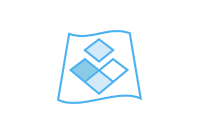

In [3]:
lunar_dem = gis.content.get('beae2f7947704c938eb957c6deb2fa2b')
lunar_dem

The crater feature layer will be used as the `Input Feature Class` for the training data. 

Feature layer of craters 5-20 km will be used to export training data at 500 and 5000 cell size. 

<Item title:"craters_diameter_5_20km" type:Feature Layer Collection owner:demos_deldev>
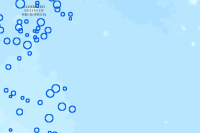

In [5]:
craters_5_20km = gis.content.get('af240e45a3ca445b88d6ec19209d3bb5')
craters_5_20km

Feature layer of craters more than 20 km will be used to export training data at 10000 cell size. 

<Item title:"craters_diameter_more_than_20km" type:Feature Layer Collection owner:demos_deldev>
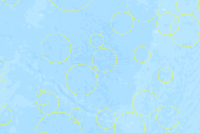

In [4]:
craters_more_than_20km = gis.content.get('36272e93ec4547abba495c797a4fb921')
craters_more_than_20km

## Methodology

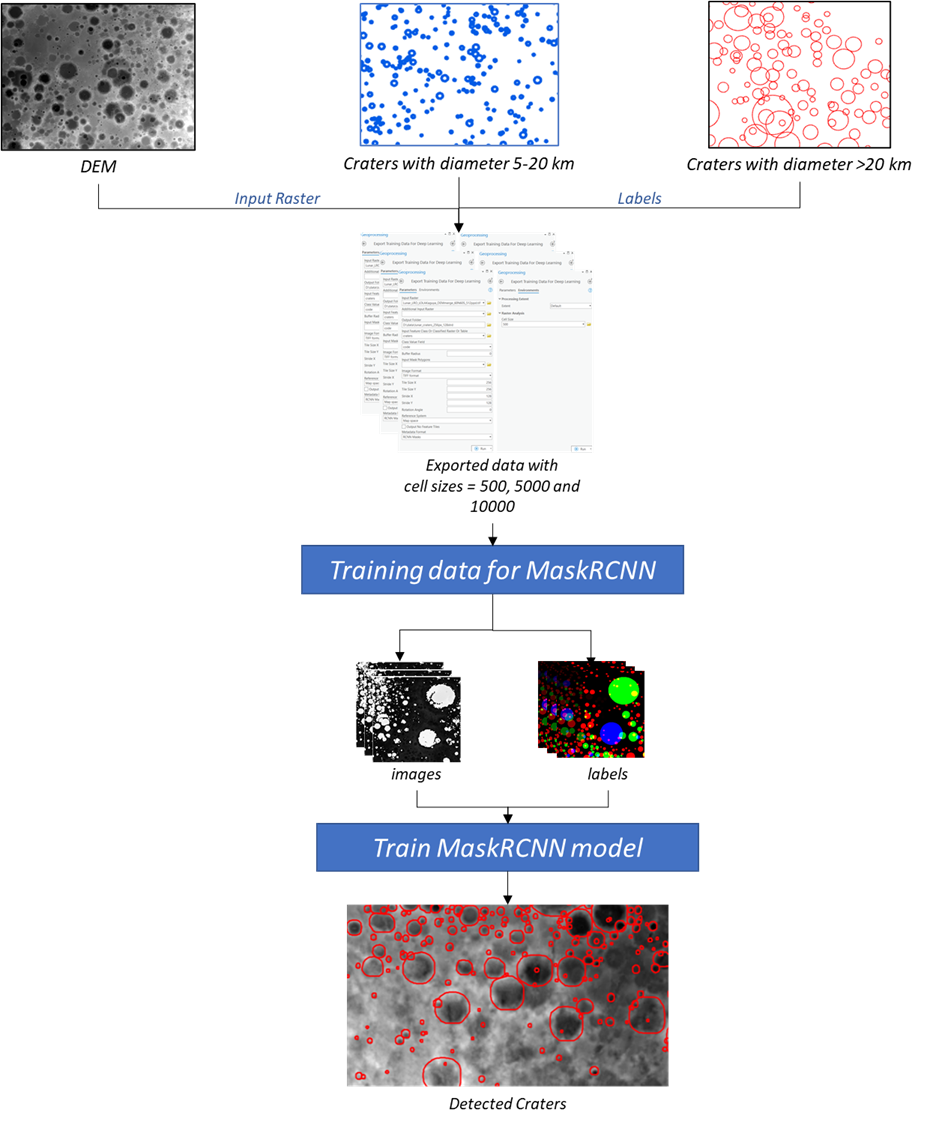

The data will be exported in the “RCNN Masks” metadata format, which is available in the [Export Training Data For Deep Learning tool](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/export-training-data-for-deep-learning.htm). This tool is available in both [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) and [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server). The various inputs required by the tool are described below:

`Input Raster`: Lunar DEM

`Input Feature Class Or Classified Raster Or Table`: The craters feature layer

`Tile Size X & Tile Size Y`: 256

`Stride X & Stride Y`: 128

`Meta Data Format`: 'RCNN Masks', as we are training a MaskRCNN model.

*`Environments`*:
- `Cell Size`: The data is exported to 3 different cell sizes so that it can learn to detect craters of different diameters. The data is exported at 500, 5000, and 10000.  

- `Processing Extent`: Default

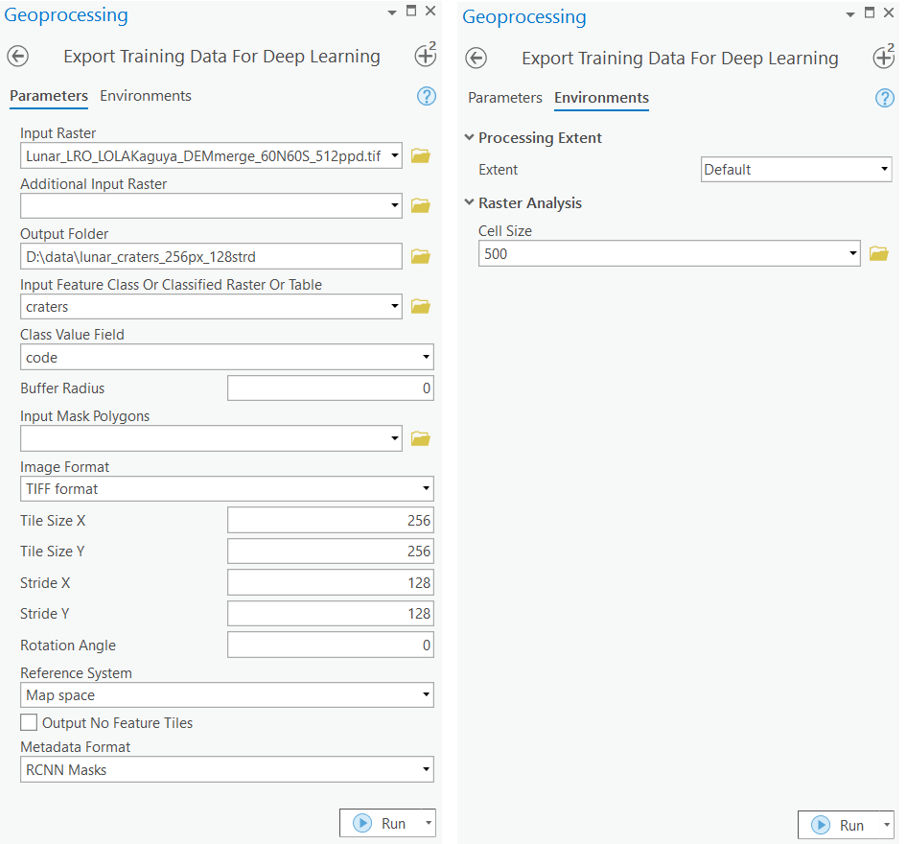

Note: The training data must be exported in the same output folder for all three cell sizes.

Inside the exported data folder, the 'images' folder contains all of the chips of the DEM, and the 'labels' folder contains the masks of the craters.

## Model training

Alternatively, we have provided a subset of training data containing a few samples that follow the same directory structure mentioned above, as well as the raster and crater feature layers used for exporting the training dataset. The provided data can be used directly to run the experiments.

<Item title:"lunar_craters_detection_from_digital_elevation_models_using_deep_learning_" type:Image Collection owner:api_data_owner>
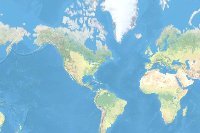

In [6]:
training_data = gis.content.get('0a4e2d4ad7bf41f6973c7e3434faf7d4')
training_data

In [7]:
filepath = training_data.download(file_name=training_data.name)

In [8]:
#Extract the data from the zipped image collection
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

### Prepare data

In [9]:
output_path = Path(os.path.join(os.path.splitext(filepath)[0]))

In [10]:
data = prepare_data(output_path, batch_size=8)

### Visualize a few samples from your training data

To get a sense of what the training data looks like, the `arcgis.learn.show_batch()` method will randomly select a few training chips and visualize them.

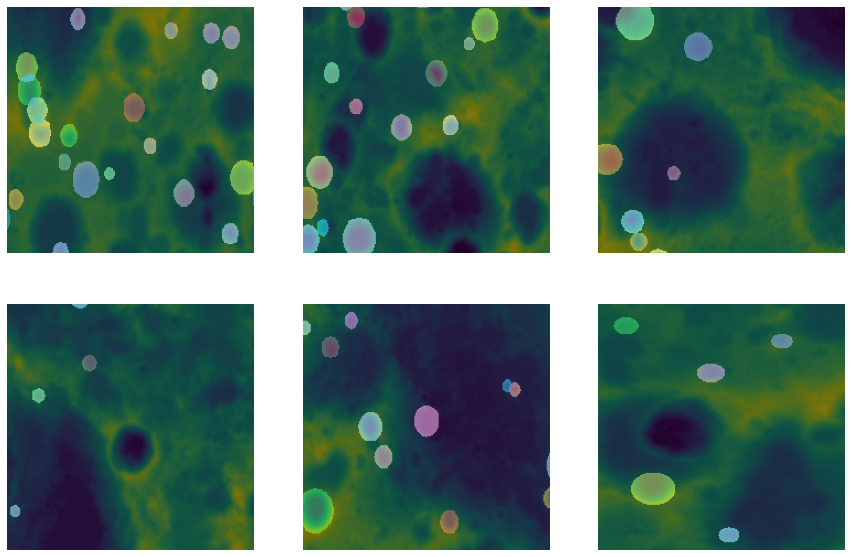

In [12]:
data.show_batch(rows=2)

### Load model architecture

The `arcgis.learn` module provides the `MaskRCNN` model for instance segmentation tasks. `MaskRCNN` is based on a pretrained convolutional neural network, like `ResNet`, that acts as the 'backbone'. More details about `MaskRCNN` can be found [here](https://developers.arcgis.com/python/guide/how-maskrcnn-works/).

In [13]:
model = MaskRCNN(data)

### Tuning for optimal learning rate

Learning rate is one of the most important hyperparameters in model training. ArcGIS API for Python provides a learning rate finder that automatically chooses the optimal learning rate for you.

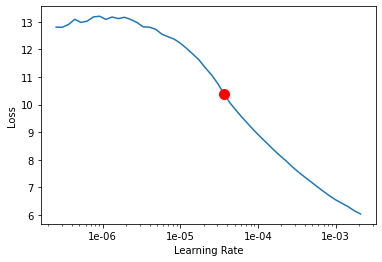

3.630780547701014e-05

In [14]:
lr = model.lr_find()
lr

### Fit the model

Next, the model is trained for a few epochs, with `early_stopping=True` and the learning rate recommended above.

In [15]:
model.fit(100, lr, early_stopping=True)

epoch,train_loss,valid_loss,time
0,6.944399,5.095363,01:00
1,3.083338,2.410944,01:04
2,2.264618,2.287425,01:08
3,2.102938,2.249945,01:09
4,2.032436,2.229557,01:15
5,2.009923,2.240452,01:15
6,1.982428,2.191599,01:12
7,1.960892,2.277536,01:17
8,1.991066,2.217761,01:17
9,1.938140,2.132267,01:17


Epoch 56: early stopping


Here, the model training automatically stopped at the 56th epoch. We can see reasonable results, as both the training and validation losses decreased considerably, indicating that the model is learning to translate between different domains of imagery.

### Save the model

Here, we will save the trained model as a 'Deep Learning Package' ('.dlpk'). The Deep Learning Package format is the standard format used when deploying deep learning models on the ArcGIS platform.

In [16]:
model.save("moon_mrcnn_2", publish=True)

Published DLPK Item Id: 81e635734e1b4d558cd51e2cee44833a


WindowsPath('C:/Users/shi10484/AppData/Local/Temp/lunar_craters_detection_from_digital_elevation_models_using_deep_learning/models/moon_mrcnn_2')

### Visualize results in validation set

It is a good practice to view the results of the model viz-a-viz the ground truth. The `model.show_results()` method can be used to display the detected craters. Each detection is visualized as a mask by default.

In [17]:
model.show_results(rows=2, mask_threshold=0.7)

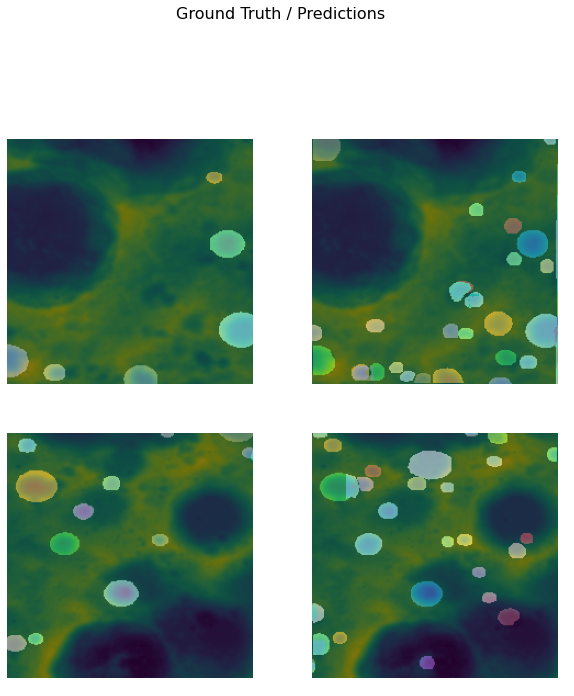

### Accuracy assessment

For the accuracy assessment, we can compute the average precision score for the trained model. Average precision will compute the average precision on the validation set for each class. We can compute the average precision score by calling `model.average_precision_score`. It takes the following parameters:

- `detect_thresh`: The probability above which a detection will be considered for computing the average precision.
- `iou_thresh`: The intersection over union threshold with the ground truth labels, above which a predicted bounding box will be considered a true positive.
- `mean`: If set to `False`, will return the class-wise average precision. Otherwise will return the mean average precision.

In [18]:
model.average_precision_score()

{'1': 0.4536149187175708}

## Model inferencing

After training the `MaskRCNN` model and saving the weights of the detected crater masks, we can use the [Detect Objects Using Deep Learning](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/detect-objects-using-deep-learning.htm) tool available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) and [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image/options/arcgis-image-server?rsource=https%3A%2F%2Fwww.esri.com%2Fen-us%2Farcgis%2Fproducts%2Farcgis-image-server).

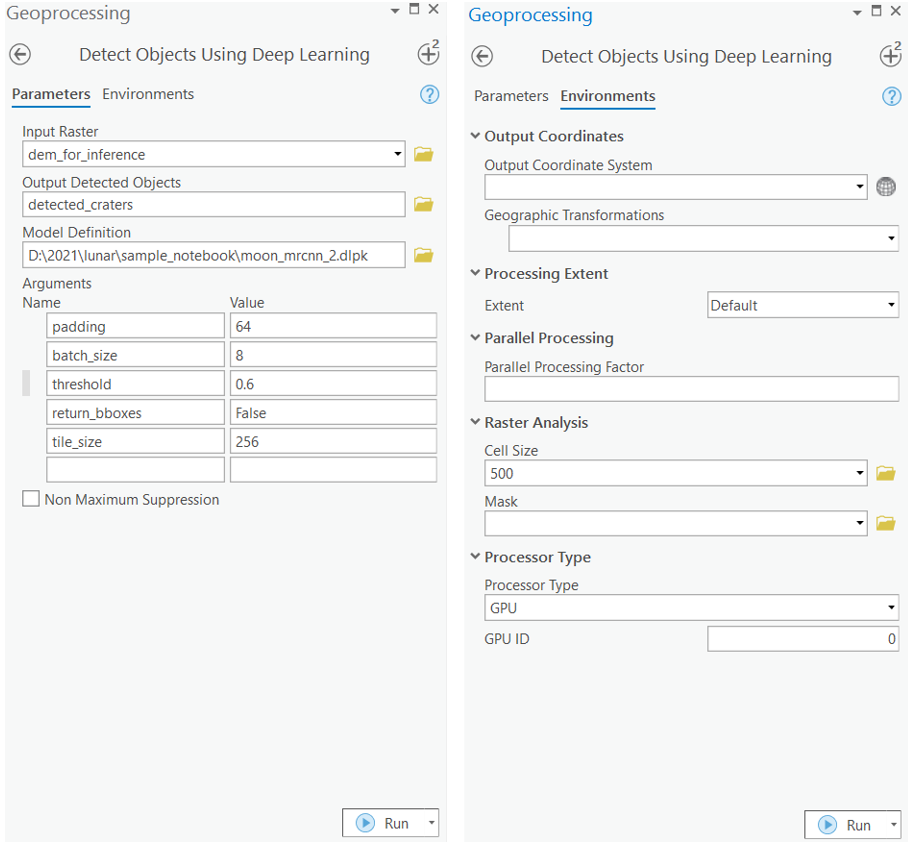

`arcpy.ia.DetectObjectsUsingDeepLearning(in_raster="dem_for_inference",
out_detected_objects=r"\\detected_craters",
in_model_definition=r"\\models\moon_mrcnn_2\moon_mrcnn_2.dlpk",
model_arguments ="padding 56;batch_size 4;threshold 0.6;return_bboxes False",
run_nms="NMS",
confidence_score_field="Confidence",
class_value_field="Class",
max_overlap_ratio=0,
processing_mode="PROCESS_AS_MOSAICKED_IMAGE")`

The inferencing above was done on the following cell sizes: 500m (small craters), 5000m (medium-sized craters), and 10,000m (large craters). All of the inferenced outputs were then merged together to get the final feature layer, which consists of all the detected craters.

## Results visualization<a class="anchor" id="1"></a>

Finally, after we have used ArcGIS Pro to detect craters in two different areas, we will publish the results to our portal and visualize them as maps.

In [19]:
from arcgis.mapping import WebMap
## Area1 Craters
LunarArea1 = gis.content.get('1a76ed548cfc4e159d860ae253e5ecc3')
map1 = WebMap(LunarArea1)
map1

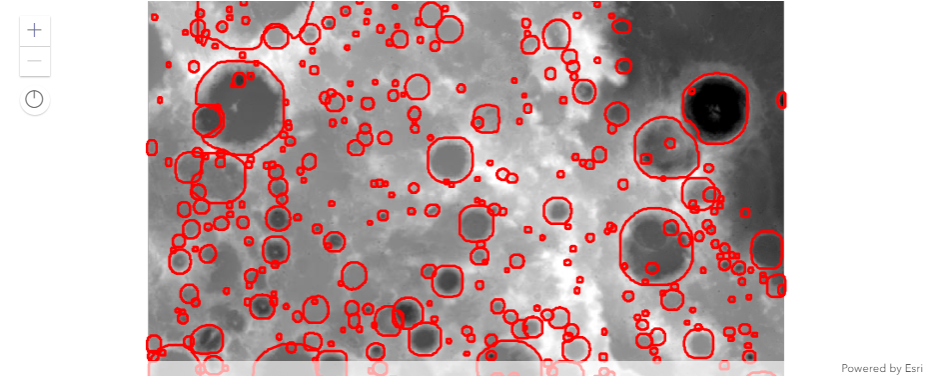

In [20]:
## Area2 Craters
LunarArea2 = gis.content.get('2ce5ad91fab649c7982dde750cce3390')
map2 = WebMap(LunarArea2)
map2

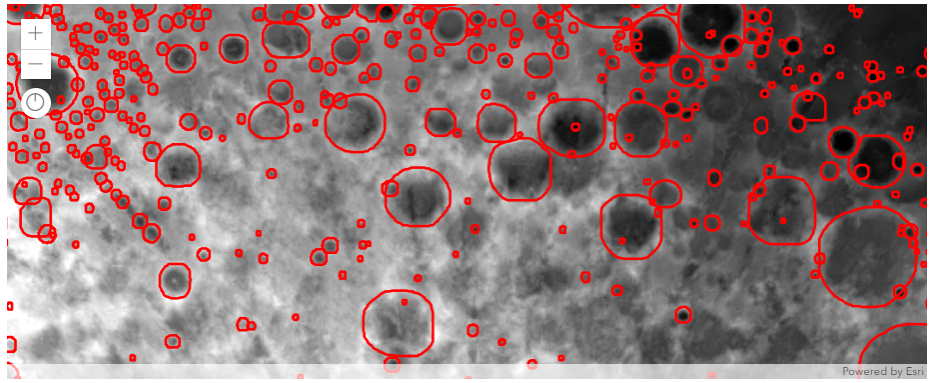

In the maps above, we can see that the trained `MaskRCNN` model was able to accurately detect craters of varying sizes. While the training data that was provided to the model contained craters digitized as circle features, the model was even able to learn to detect more accurate, non-circular boundaries of the craters.

## Conclusion

This notebook showcased how instance segmentation models, like `MaskRCNN`, can be used to automatically detect lunar craters using a DEM. We also demonstrated how custom transformations based on the data, irrespective of already present standard transformations, can be added during data preparation to achieve better performance.